# Preguntas de Negocio - PRODUCTOS Y STOCK

Este notebook responde las siguientes preguntas de negocio relacionadas con productos y stock:
1. ¿Qué productos tienen alto stock pero bajas ventas?
2. ¿Cuántos productos están actualmente fuera de stock?
3. ¿Cuáles son los productos peor calificados?
4. ¿Qué productos tienen mayor cantidad de reseñas?
5. ¿Qué categoría tiene el mayor valor económico vendido (no solo volumen)?


## Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

# Configurar el path para importar módulos del proyecto
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) if 'preguntas_negocio' in current_dir else current_dir

# Agregar el directorio raíz al path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importar DBConnector
try:
    from database.db_connector import DBConnector
except ImportError:
    # Intentar con mayúscula (compatibilidad con notebooks existentes)
    from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 1. ¿Qué productos tienen alto stock pero bajas ventas?


PRODUCTOS CON ALTO STOCK PERO BAJAS VENTAS (Top 10)
 producto_id              producto_nombre  stock  precio           categoria_nombre  total_vendido  ratio_stock_ventas
          23  Cuaderno Universitario 100h    300    4.50         Libros y Papelería            876                0.34
          27         Alcohol en Gel 500ml    200    5.25                      Salud            803                0.25
           4       Camiseta Básica Hombre    200   14.99                       Moda            868                0.23
          13      Crema Hidratante Facial    150   15.99 Belleza y Cuidado Personal            818                0.18
          24    Set de Lápices de Colores    150    6.75         Libros y Papelería            856                0.18
           5           Jeans Skinny Mujer    150   39.99                       Moda            887                0.17
           7    Sartén Antiadherente 24cm    120   19.99             Hogar y Cocina            693                0

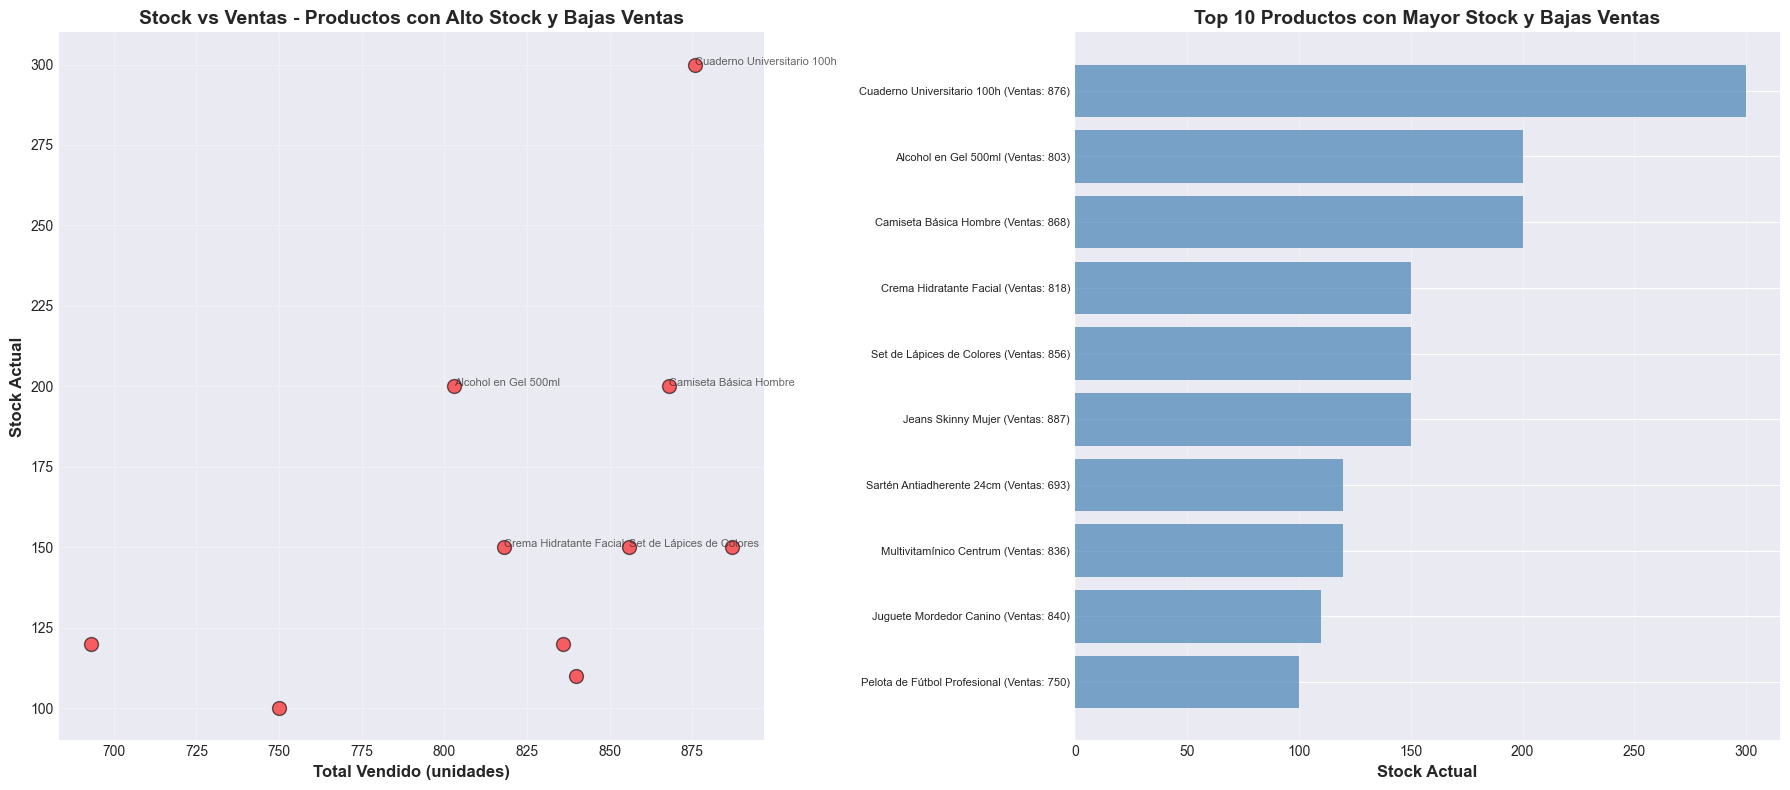


📊 Resumen:
   • Total de productos analizados: 10
   • Producto con mayor stock y bajas ventas: Cuaderno Universitario 100h
   • Stock total de estos productos: 1,600
   • Valor total del stock: $23,288.30


In [8]:
# Consulta SQL para identificar productos con alto stock pero bajas ventas
query_alto_stock_bajas_ventas = """
SELECT 
    p.producto_id,
    p.nombre AS producto_nombre,
    p.stock,
    p.precio,
    c.nombre AS categoria_nombre,
    COALESCE(SUM(detalle.cantidad), 0) AS total_vendido,
    CASE 
        WHEN COALESCE(SUM(detalle.cantidad), 0) = 0 THEN NULL
        ELSE ROUND((p.stock::numeric / NULLIF(SUM(detalle.cantidad), 0)), 2)
    END AS ratio_stock_ventas
FROM productos p
LEFT JOIN detalle_ordenes detalle ON p.producto_id = detalle.producto_id
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
GROUP BY p.producto_id, p.nombre, p.stock, p.precio, c.nombre
HAVING p.stock > 0  -- Solo productos con stock disponible
ORDER BY p.stock DESC, total_vendido ASC
LIMIT 10;
"""

df_alto_stock_bajas_ventas = pd.read_sql(query_alto_stock_bajas_ventas, engine)

print("=" * 100)
print("PRODUCTOS CON ALTO STOCK PERO BAJAS VENTAS (Top 10)")
print("=" * 100)
print(df_alto_stock_bajas_ventas.to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Stock vs Ventas (scatter plot)
top_20 = df_alto_stock_bajas_ventas.head(20)
ax1.scatter(top_20['total_vendido'], top_20['stock'], 
           s=100, alpha=0.6, c='red', edgecolors='black', linewidth=1)
ax1.set_xlabel('Total Vendido (unidades)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Stock Actual', fontsize=12, fontweight='bold')
ax1.set_title('Stock vs Ventas - Productos con Alto Stock y Bajas Ventas', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Agregar etiquetas para los top 5
for idx, row in top_20.head(5).iterrows():
    ax1.annotate(row['producto_nombre'][:30], 
                (row['total_vendido'], row['stock']),
                fontsize=8, alpha=0.7)

# Gráfico 2: Top 10 productos por stock
top_10 = df_alto_stock_bajas_ventas.head(10)
ax2.barh(range(len(top_10)), top_10['stock'], color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([f"{row['producto_nombre'][:40]} (Ventas: {row['total_vendido']})" 
                     for _, row in top_10.iterrows()], fontsize=8)
ax2.set_xlabel('Stock Actual', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Productos con Mayor Stock y Bajas Ventas', 
             fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de productos analizados: {len(df_alto_stock_bajas_ventas)}")
print(f"   • Producto con mayor stock y bajas ventas: {df_alto_stock_bajas_ventas.iloc[0]['producto_nombre']}")
print(f"   • Stock total de estos productos: {df_alto_stock_bajas_ventas['stock'].sum():,}")
print(f"   • Valor total del stock: ${(df_alto_stock_bajas_ventas['stock'] * df_alto_stock_bajas_ventas['precio']).sum():,.2f}")


## 2. ¿Cuántos productos están actualmente fuera de stock?


ESTADÍSTICAS GENERALES DE STOCK
 total_productos  productos_fuera_stock  productos_stock_bajo  productos_stock_ok  porcentaje_fuera_stock
              36                      0                     0                  36                     0.0

PRODUCTOS FUERA DE STOCK (Total: 0)
✓ No hay productos fuera de stock


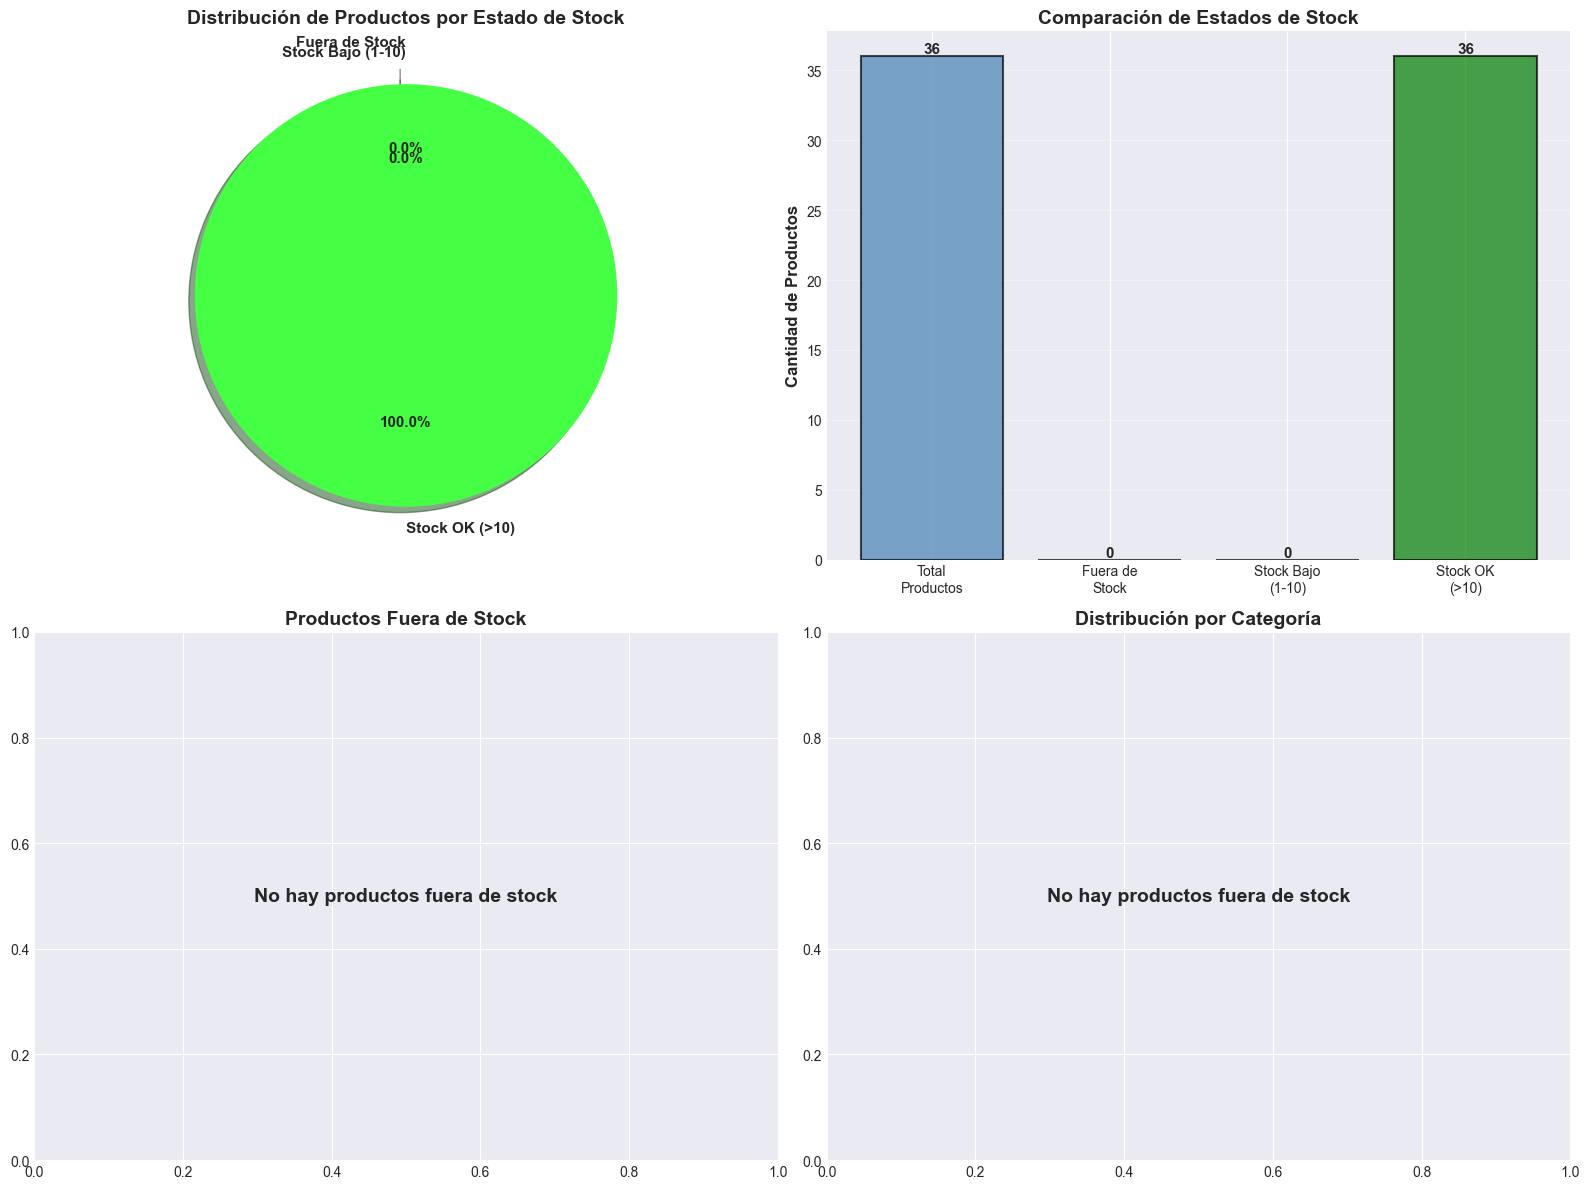


📊 Resumen:
   • Total de productos: 36
   • Productos fuera de stock: 0 (0.0%)
   • Productos con stock bajo (1-10): 0
   • Productos con stock OK (>10): 36


In [9]:
# Consulta SQL para identificar productos fuera de stock
query_fuera_stock = """
SELECT 
    p.producto_id,
    p.nombre AS producto_nombre,
    p.stock,
    p.precio,
    c.nombre AS categoria_nombre,
    COALESCE(SUM(detalle.cantidad), 0) AS total_vendido_historico,
    COALESCE(SUM(detalle.cantidad * detalle.precio_unitario), 0) AS total_recaudado_historico
FROM productos p
LEFT JOIN detalle_ordenes detalle ON p.producto_id = detalle.producto_id
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
WHERE p.stock = 0
GROUP BY p.producto_id, p.nombre, p.stock, p.precio, c.nombre
ORDER BY total_recaudado_historico DESC;
"""

df_fuera_stock = pd.read_sql(query_fuera_stock, engine)

# Consulta adicional para estadísticas generales
query_stats_stock = """
SELECT 
    COUNT(*) AS total_productos,
    COUNT(CASE WHEN stock = 0 THEN 1 END) AS productos_fuera_stock,
    COUNT(CASE WHEN stock > 0 AND stock <= 10 THEN 1 END) AS productos_stock_bajo,
    COUNT(CASE WHEN stock > 10 THEN 1 END) AS productos_stock_ok,
    ROUND(COUNT(CASE WHEN stock = 0 THEN 1 END)::numeric / COUNT(*)::numeric * 100, 2) AS porcentaje_fuera_stock
FROM productos;
"""

df_stats_stock = pd.read_sql(query_stats_stock, engine)

print("=" * 100)
print("ESTADÍSTICAS GENERALES DE STOCK")
print("=" * 100)
print(df_stats_stock.to_string(index=False))

print("\n" + "=" * 100)
print(f"PRODUCTOS FUERA DE STOCK (Total: {len(df_fuera_stock)})")
print("=" * 100)
if len(df_fuera_stock) > 0:
    print(df_fuera_stock.to_string(index=False))
else:
    print("✓ No hay productos fuera de stock")

# Visualización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Distribución de stock (pie chart)
stats = df_stats_stock.iloc[0]
labels = ['Fuera de Stock', 'Stock Bajo (1-10)', 'Stock OK (>10)']
sizes = [stats['productos_fuera_stock'], 
         stats['productos_stock_bajo'], 
         stats['productos_stock_ok']]
colors = ['#ff4444', '#ffaa00', '#44ff44']
explode = (0.1, 0.05, 0)  # Resaltar fuera de stock

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Distribución de Productos por Estado de Stock', 
              fontsize=14, fontweight='bold')

# Gráfico 2: Barras comparativas
categories = ['Total\nProductos', 'Fuera de\nStock', 'Stock Bajo\n(1-10)', 'Stock OK\n(>10)']
values = [stats['total_productos'], 
          stats['productos_fuera_stock'],
          stats['productos_stock_bajo'],
          stats['productos_stock_ok']]
colors_bar = ['steelblue', 'red', 'orange', 'green']

bars = ax2.bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Cantidad de Productos', fontsize=12, fontweight='bold')
ax2.set_title('Comparación de Estados de Stock', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico 3: Top 15 productos fuera de stock por valor histórico
if len(df_fuera_stock) > 0:
    top_15_fuera = df_fuera_stock.head(15)
    ax3.barh(range(len(top_15_fuera)), top_15_fuera['total_recaudado_historico'], 
            color='crimson', alpha=0.7)
    ax3.set_yticks(range(len(top_15_fuera)))
    ax3.set_yticklabels([f"{row['producto_nombre'][:40]}" 
                        for _, row in top_15_fuera.iterrows()], fontsize=8)
    ax3.set_xlabel('Total Recaudado Histórico ($)', fontsize=12, fontweight='bold')
    ax3.set_title('Top 15 Productos Fuera de Stock por Valor Histórico', 
                 fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    ax3.invert_yaxis()
else:
    ax3.text(0.5, 0.5, 'No hay productos fuera de stock', 
            ha='center', va='center', fontsize=14, fontweight='bold',
            transform=ax3.transAxes)
    ax3.set_title('Productos Fuera de Stock', fontsize=14, fontweight='bold')

# Gráfico 4: Distribución por categoría (si hay productos fuera de stock)
if len(df_fuera_stock) > 0:
    categoria_counts = df_fuera_stock['categoria_nombre'].value_counts().head(10)
    ax4.barh(range(len(categoria_counts)), categoria_counts.values, 
            color='darkred', alpha=0.7)
    ax4.set_yticks(range(len(categoria_counts)))
    ax4.set_yticklabels(categoria_counts.index, fontsize=9)
    ax4.set_xlabel('Cantidad de Productos', fontsize=12, fontweight='bold')
    ax4.set_title('Top 10 Categorías con Productos Fuera de Stock', 
                 fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, 'No hay productos fuera de stock', 
            ha='center', va='center', fontsize=14, fontweight='bold',
            transform=ax4.transAxes)
    ax4.set_title('Distribución por Categoría', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de productos: {int(stats['total_productos'])}")
print(f"   • Productos fuera de stock: {int(stats['productos_fuera_stock'])} ({stats['porcentaje_fuera_stock']}%)")
print(f"   • Productos con stock bajo (1-10): {int(stats['productos_stock_bajo'])}")
print(f"   • Productos con stock OK (>10): {int(stats['productos_stock_ok'])}")
if len(df_fuera_stock) > 0:
    print(f"   • Valor histórico total de productos fuera de stock: ${df_fuera_stock['total_recaudado_historico'].sum():,.2f}")


## 3. ¿Cuáles son los productos peor calificados?


PRODUCTOS PEOR CALIFICADOS (Top 10 - Mínimo 3 reseñas)
 producto_id             producto_nombre  precio  stock      categoria_nombre  total_resenas  calificacion_promedio  calificacion_minima  calificacion_maxima  calificaciones_1  calificaciones_2  calificaciones_3  calificaciones_4  calificaciones_5
           1       Smartphone Galaxy A54  349.99     50           Electrónica            164                   2.77                    1                    5                41                41                18                43                21
           6       Zapatillas Deportivas   59.99     80                  Moda            183                   2.82                    1                    5                45                45                28                28                37
          19        Aceite de Motor 5W30   22.90     80            Automotriz            189                   2.83                    1                    5                48                48        

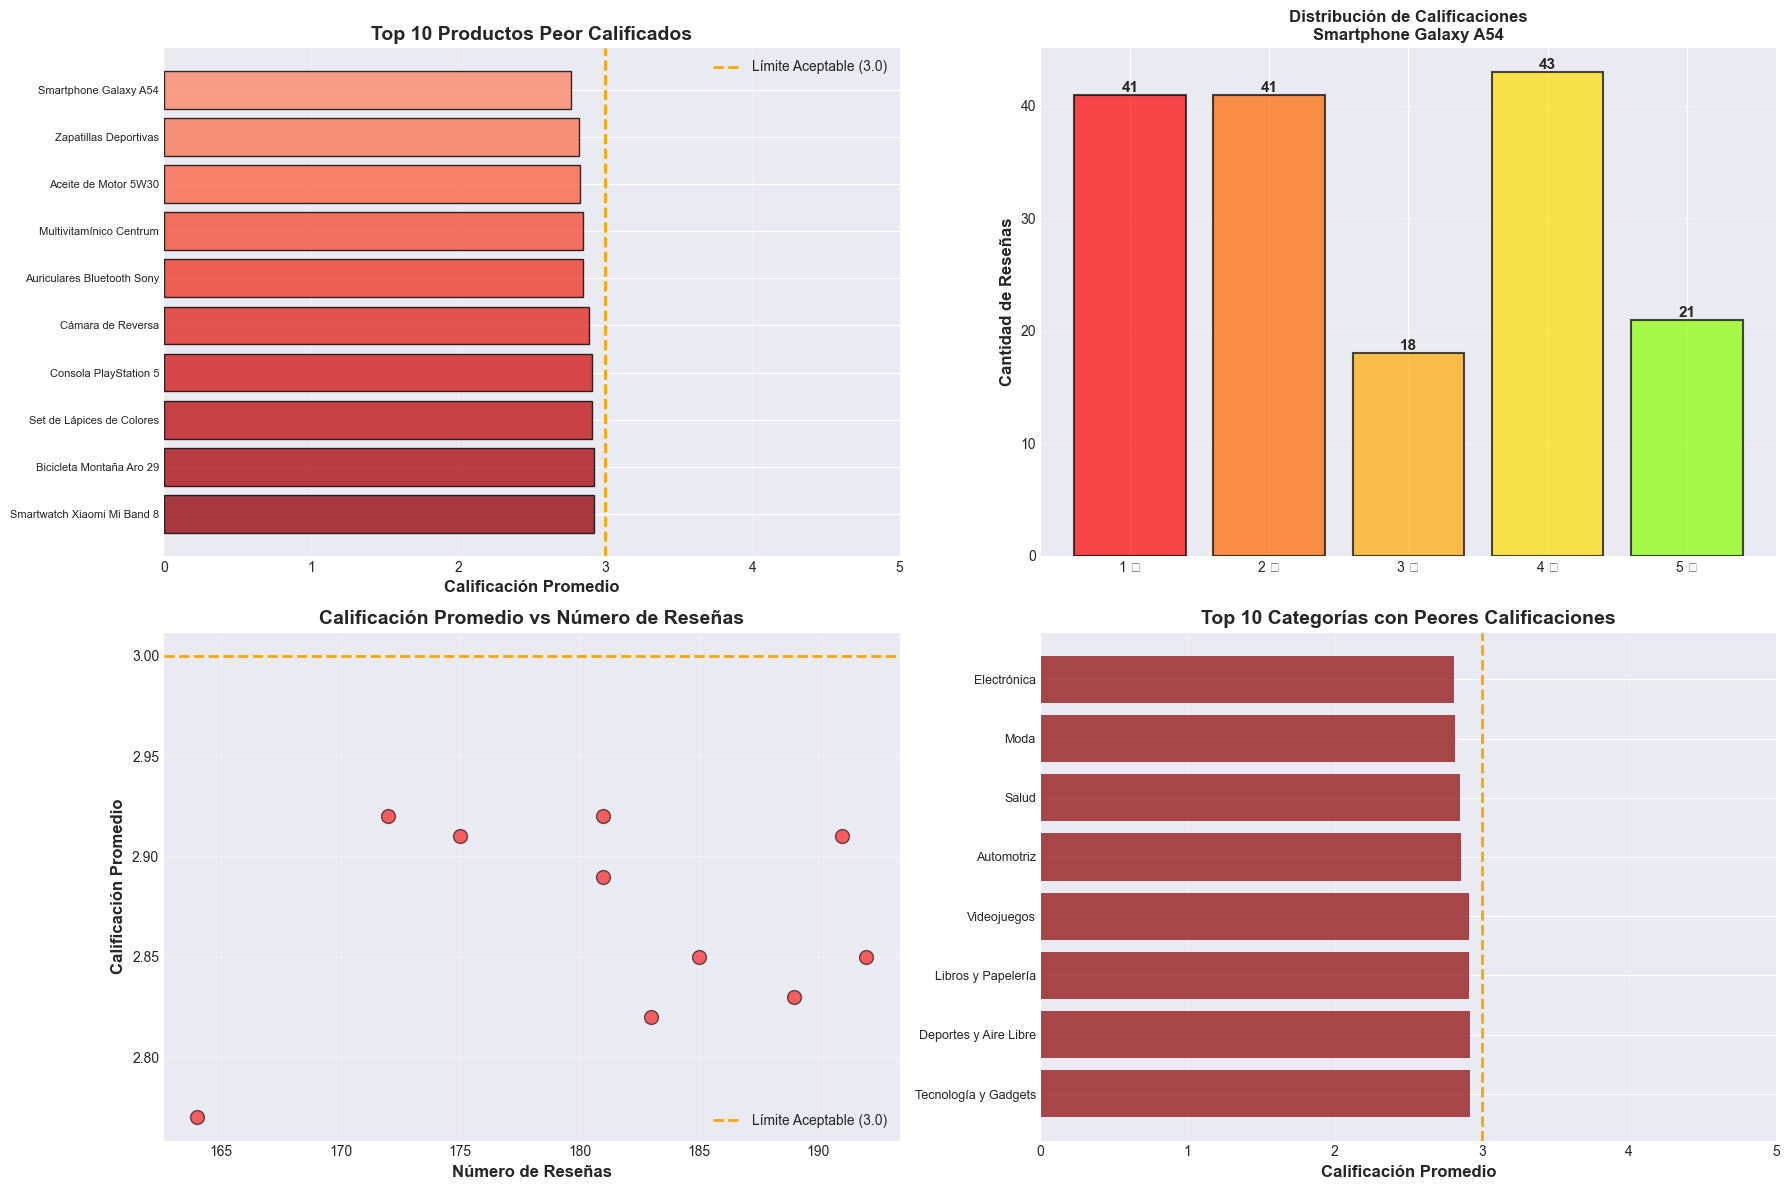


📊 Resumen:
   • Total de productos analizados (con ≥3 reseñas): 10
   • Producto peor calificado: Smartphone Galaxy A54
   • Calificación promedio del peor producto: 2.77/5.0
   • Calificación promedio general (Top 10): 2.87/5.0
   • Productos con calificación < 3.0: 10


In [11]:
# Consulta SQL para identificar productos peor calificados
query_peor_calificados = """
SELECT 
    p.producto_id,
    p.nombre AS producto_nombre,
    p.precio,
    p.stock,
    c.nombre AS categoria_nombre,
    COUNT(rp.resena_id) AS total_resenas,
    ROUND(AVG(rp.calificacion)::numeric, 2) AS calificacion_promedio,
    MIN(rp.calificacion) AS calificacion_minima,
    MAX(rp.calificacion) AS calificacion_maxima,
    COUNT(CASE WHEN rp.calificacion = 1 THEN 1 END) AS calificaciones_1,
    COUNT(CASE WHEN rp.calificacion = 2 THEN 1 END) AS calificaciones_2,
    COUNT(CASE WHEN rp.calificacion = 3 THEN 1 END) AS calificaciones_3,
    COUNT(CASE WHEN rp.calificacion = 4 THEN 1 END) AS calificaciones_4,
    COUNT(CASE WHEN rp.calificacion = 5 THEN 1 END) AS calificaciones_5
FROM productos p
INNER JOIN resenas_productos rp ON p.producto_id = rp.producto_id
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
GROUP BY p.producto_id, p.nombre, p.precio, p.stock, c.nombre
HAVING COUNT(rp.resena_id) >= 3  -- Solo productos con al menos 3 reseñas
ORDER BY calificacion_promedio ASC, total_resenas DESC
LIMIT 10;
"""

df_peor_calificados = pd.read_sql(query_peor_calificados, engine)

print("=" * 100)
print("PRODUCTOS PEOR CALIFICADOS (Top 10 - Mínimo 3 reseñas)")
print("=" * 100)
print(df_peor_calificados.to_string(index=False))

# Visualización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Top 15 productos peor calificados
top_10_peor = df_peor_calificados.head(10)
colors_peor = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_10_peor)))
ax1.barh(range(len(top_10_peor)), top_10_peor['calificacion_promedio'], 
        color=colors_peor, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_yticks(range(len(top_10_peor)))
ax1.set_yticklabels([f"{row['producto_nombre'][:45]}" 
                     for _, row in top_10_peor.iterrows()], fontsize=8)
ax1.set_xlabel('Calificación Promedio', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Productos Peor Calificados', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 5)
ax1.axvline(x=3, color='orange', linestyle='--', linewidth=2, label='Límite Aceptable (3.0)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Gráfico 2: Distribución de calificaciones para el peor producto
if len(df_peor_calificados) > 0:
    peor_producto = df_peor_calificados.iloc[0]
    calificaciones = [peor_producto['calificaciones_1'], 
                     peor_producto['calificaciones_2'],
                     peor_producto['calificaciones_3'],
                     peor_producto['calificaciones_4'],
                     peor_producto['calificaciones_5']]
    labels_calif = ['1 ⭐', '2 ⭐', '3 ⭐', '4 ⭐', '5 ⭐']
    colors_calif = ['#ff0000', '#ff6600', '#ffaa00', '#ffdd00', '#88ff00']
    
    ax2.bar(labels_calif, calificaciones, color=colors_calif, alpha=0.7, 
           edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Cantidad de Reseñas', fontsize=12, fontweight='bold')
    ax2.set_title(f'Distribución de Calificaciones\n{peor_producto["producto_nombre"][:50]}', 
                 fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(calificaciones):
        if v > 0:
            ax2.text(i, v, str(int(v)), ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')

# Gráfico 3: Calificación promedio vs Número de reseñas
ax3.scatter(df_peor_calificados['total_resenas'], 
           df_peor_calificados['calificacion_promedio'],
           s=100, alpha=0.6, c='red', edgecolors='black', linewidth=1)
ax3.set_xlabel('Número de Reseñas', fontsize=12, fontweight='bold')
ax3.set_ylabel('Calificación Promedio', fontsize=12, fontweight='bold')
ax3.set_title('Calificación Promedio vs Número de Reseñas', 
             fontsize=14, fontweight='bold')
ax3.axhline(y=3, color='orange', linestyle='--', linewidth=2, label='Límite Aceptable (3.0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Top 10 categorías con peores calificaciones
categoria_promedio = df_peor_calificados.groupby('categoria_nombre').agg({
    'calificacion_promedio': 'mean',
    'producto_id': 'count'
}).reset_index()
categoria_promedio.columns = ['categoria_nombre', 'calificacion_promedio', 'num_productos']
categoria_promedio = categoria_promedio.sort_values('calificacion_promedio').head(10)

ax4.barh(range(len(categoria_promedio)), categoria_promedio['calificacion_promedio'], 
        color='darkred', alpha=0.7)
ax4.set_yticks(range(len(categoria_promedio)))
ax4.set_yticklabels(categoria_promedio['categoria_nombre'], fontsize=9)
ax4.set_xlabel('Calificación Promedio', fontsize=12, fontweight='bold')
ax4.set_title('Top 10 Categorías con Peores Calificaciones', 
             fontsize=14, fontweight='bold')
ax4.set_xlim(0, 5)
ax4.axvline(x=3, color='orange', linestyle='--', linewidth=2)
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de productos analizados (con ≥3 reseñas): {len(df_peor_calificados)}")
if len(df_peor_calificados) > 0:
    print(f"   • Producto peor calificado: {df_peor_calificados.iloc[0]['producto_nombre']}")
    print(f"   • Calificación promedio del peor producto: {df_peor_calificados.iloc[0]['calificacion_promedio']:.2f}/5.0")
    print(f"   • Calificación promedio general (Top 10): {df_peor_calificados['calificacion_promedio'].mean():.2f}/5.0")
    print(f"   • Productos con calificación < 3.0: {len(df_peor_calificados[df_peor_calificados['calificacion_promedio'] < 3.0])}")


## 4. ¿Qué productos tienen mayor cantidad de reseñas?


PRODUCTOS CON MAYOR CANTIDAD DE RESEÑAS (Top 10)
 producto_id              producto_nombre  precio  stock      categoria_nombre  total_resenas  calificacion_promedio  calificacion_minima  calificacion_maxima  calificaciones_5  calificaciones_4  calificaciones_3  calificaciones_2  calificaciones_1  porcentaje_positivas
           8       Juego de Sábanas Queen   49.99     60        Hogar y Cocina            198                   3.01                    1                    5                44                50                17                37                50                 47.47
          18       Juego de Mesa Monopoly   35.00     50     Juguetes y Juegos            198                   3.19                    1                    5                48                51                26                36                37                 50.00
          20   Limpiaparabrisas Universal   15.50     60            Automotriz            197                   3.00                    1 

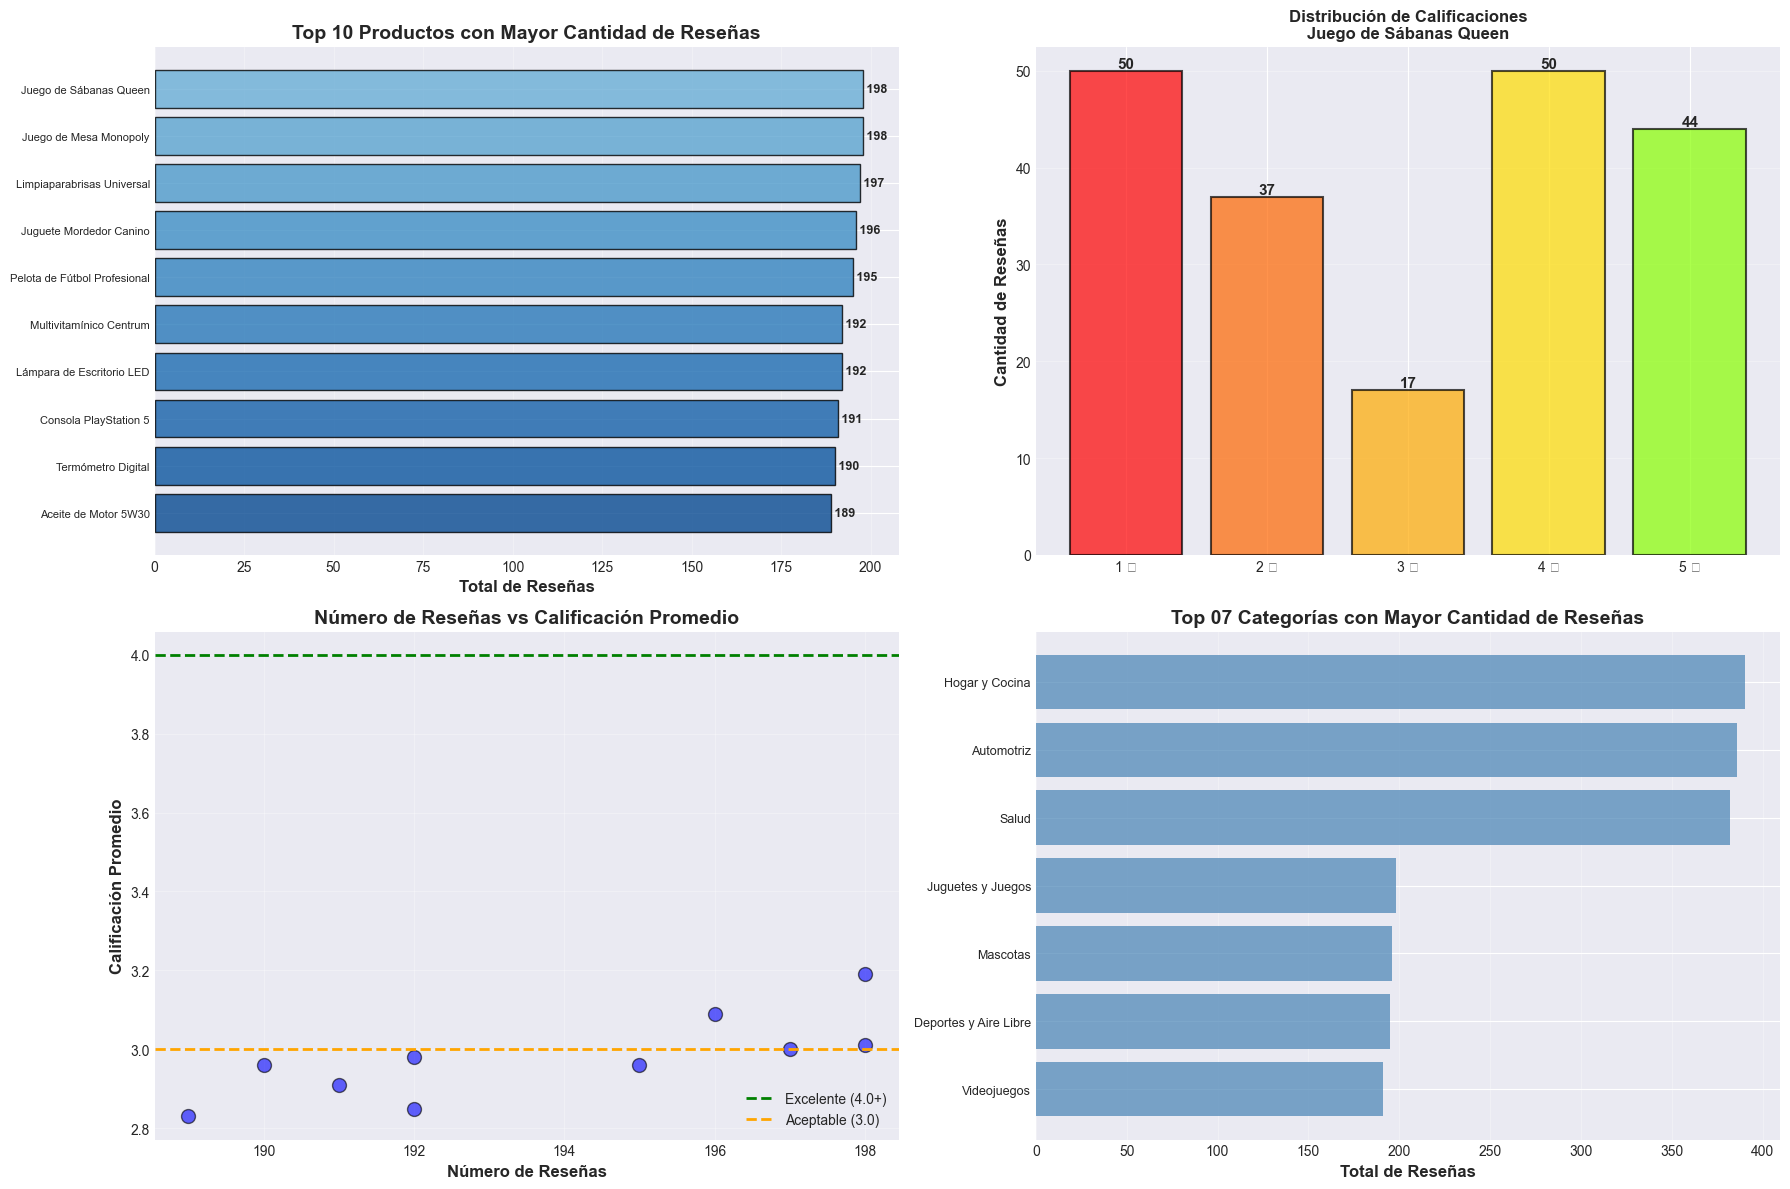


📊 Resumen:
   • Total de productos analizados: 10
   • Producto con más reseñas: Juego de Sábanas Queen
   • Total de reseñas del producto top: 198
   • Calificación promedio del producto top: 3.01/5.0
   • Total de reseñas (Top 10): 1,938
   • Calificación promedio general (Top 10): 2.98/5.0
   • Productos con calificación ≥ 4.0: 0


In [14]:
# Consulta SQL para identificar productos con mayor cantidad de reseñas
query_mas_resenas = """
SELECT 
    p.producto_id,
    p.nombre AS producto_nombre,
    p.precio,
    p.stock,
    c.nombre AS categoria_nombre,
    COUNT(rp.resena_id) AS total_resenas,
    ROUND(AVG(rp.calificacion)::numeric, 2) AS calificacion_promedio,
    MIN(rp.calificacion) AS calificacion_minima,
    MAX(rp.calificacion) AS calificacion_maxima,
    COUNT(CASE WHEN rp.calificacion = 5 THEN 1 END) AS calificaciones_5,
    COUNT(CASE WHEN rp.calificacion = 4 THEN 1 END) AS calificaciones_4,
    COUNT(CASE WHEN rp.calificacion = 3 THEN 1 END) AS calificaciones_3,
    COUNT(CASE WHEN rp.calificacion = 2 THEN 1 END) AS calificaciones_2,
    COUNT(CASE WHEN rp.calificacion = 1 THEN 1 END) AS calificaciones_1,
    ROUND((COUNT(CASE WHEN rp.calificacion >= 4 THEN 1 END)::numeric / 
           NULLIF(COUNT(rp.resena_id), 0)::numeric * 100), 2) AS porcentaje_positivas
FROM productos p
INNER JOIN resenas_productos rp ON p.producto_id = rp.producto_id
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
GROUP BY p.producto_id, p.nombre, p.precio, p.stock, c.nombre
ORDER BY total_resenas DESC
LIMIT 10;
"""

df_mas_resenas = pd.read_sql(query_mas_resenas, engine)

print("=" * 100)
print("PRODUCTOS CON MAYOR CANTIDAD DE RESEÑAS (Top 10)")
print("=" * 100)
print(df_mas_resenas.to_string(index=False))

# Visualización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Top 10 productos por cantidad de reseñas
top_10_resenas = df_mas_resenas.head(10)
colors_resenas = plt.cm.Blues(np.linspace(0.5, 0.9, len(top_10_resenas)))
ax1.barh(range(len(top_10_resenas)), top_10_resenas['total_resenas'], 
        color=colors_resenas, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_yticks(range(len(top_10_resenas)))
ax1.set_yticklabels([f"{row['producto_nombre'][:45]}" 
                     for _, row in top_10_resenas.iterrows()], fontsize=8)
ax1.set_xlabel('Total de Reseñas', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Productos con Mayor Cantidad de Reseñas', 
             fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Agregar valores en las barras
for i, (idx, row) in enumerate(top_10_resenas.iterrows()):
    ax1.text(row['total_resenas'], i, f" {int(row['total_resenas'])}", 
            va='center', fontsize=9, fontweight='bold')

# Gráfico 2: Distribución de calificaciones para el producto con más reseñas
if len(df_mas_resenas) > 0:
    producto_top = df_mas_resenas.iloc[0]
    calificaciones = [producto_top['calificaciones_1'], 
                     producto_top['calificaciones_2'],
                     producto_top['calificaciones_3'],
                     producto_top['calificaciones_4'],
                     producto_top['calificaciones_5']]
    labels_calif = ['1 ⭐', '2 ⭐', '3 ⭐', '4 ⭐', '5 ⭐']
    colors_calif = ['#ff0000', '#ff6600', '#ffaa00', '#ffdd00', '#88ff00']
    
    ax2.bar(labels_calif, calificaciones, color=colors_calif, alpha=0.7, 
           edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Cantidad de Reseñas', fontsize=12, fontweight='bold')
    ax2.set_title(f'Distribución de Calificaciones\n{producto_top["producto_nombre"][:50]}', 
                 fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(calificaciones):
        if v > 0:
            ax2.text(i, v, str(int(v)), ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')

# Gráfico 3: Número de reseñas vs Calificación promedio
ax3.scatter(df_mas_resenas['total_resenas'], 
           df_mas_resenas['calificacion_promedio'],
           s=100, alpha=0.6, c='blue', edgecolors='black', linewidth=1)
ax3.set_xlabel('Número de Reseñas', fontsize=12, fontweight='bold')
ax3.set_ylabel('Calificación Promedio', fontsize=12, fontweight='bold')
ax3.set_title('Número de Reseñas vs Calificación Promedio', 
             fontsize=14, fontweight='bold')
ax3.axhline(y=4, color='green', linestyle='--', linewidth=2, label='Excelente (4.0+)')
ax3.axhline(y=3, color='orange', linestyle='--', linewidth=2, label='Aceptable (3.0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Top 07 categorías con más reseñas
categoria_resenas = df_mas_resenas.groupby('categoria_nombre').agg({
    'total_resenas': 'sum',
    'calificacion_promedio': 'mean'
}).reset_index()
categoria_resenas = categoria_resenas.sort_values('total_resenas', ascending=False).head(10)

ax4.barh(range(len(categoria_resenas)), categoria_resenas['total_resenas'], 
        color='steelblue', alpha=0.7)
ax4.set_yticks(range(len(categoria_resenas)))
ax4.set_yticklabels(categoria_resenas['categoria_nombre'], fontsize=9)
ax4.set_xlabel('Total de Reseñas', fontsize=12, fontweight='bold')
ax4.set_title('Top 07 Categorías con Mayor Cantidad de Reseñas', 
             fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de productos analizados: {len(df_mas_resenas)}")
if len(df_mas_resenas) > 0:
    print(f"   • Producto con más reseñas: {df_mas_resenas.iloc[0]['producto_nombre']}")
    print(f"   • Total de reseñas del producto top: {int(df_mas_resenas.iloc[0]['total_resenas'])}")
    print(f"   • Calificación promedio del producto top: {df_mas_resenas.iloc[0]['calificacion_promedio']:.2f}/5.0")
    print(f"   • Total de reseñas (Top 10): {df_mas_resenas['total_resenas'].sum():,}")
    print(f"   • Calificación promedio general (Top 10): {df_mas_resenas['calificacion_promedio'].mean():.2f}/5.0")
    print(f"   • Productos con calificación ≥ 4.0: {len(df_mas_resenas[df_mas_resenas['calificacion_promedio'] >= 4.0])}")


## 5. ¿Qué categoría tiene el mayor valor económico vendido (no solo volumen)?


CATEGORÍAS POR VALOR ECONÓMICO VENDIDO
 categoria_id           categoria_nombre                                                     categoria_descripcion  total_productos  total_ordenes  total_unidades_vendidas  valor_economico_total  precio_promedio  ticket_promedio_producto  valor_promedio_por_orden
            6          Juguetes y Juegos Juguetes para todas las edades, juegos de mesa, didácticos y electrónicos                3            586                     2622              681765.17           260.99                    260.02                   1163.42
            8         Libros y Papelería                          Libros, cuadernos, útiles escolares y de oficina                3            576                     2565              678118.98           264.46                    264.37                   1177.29
           12                Videojuegos                    Consolas, juegos físicos y digitales, accesorios gamer                3            570                     26

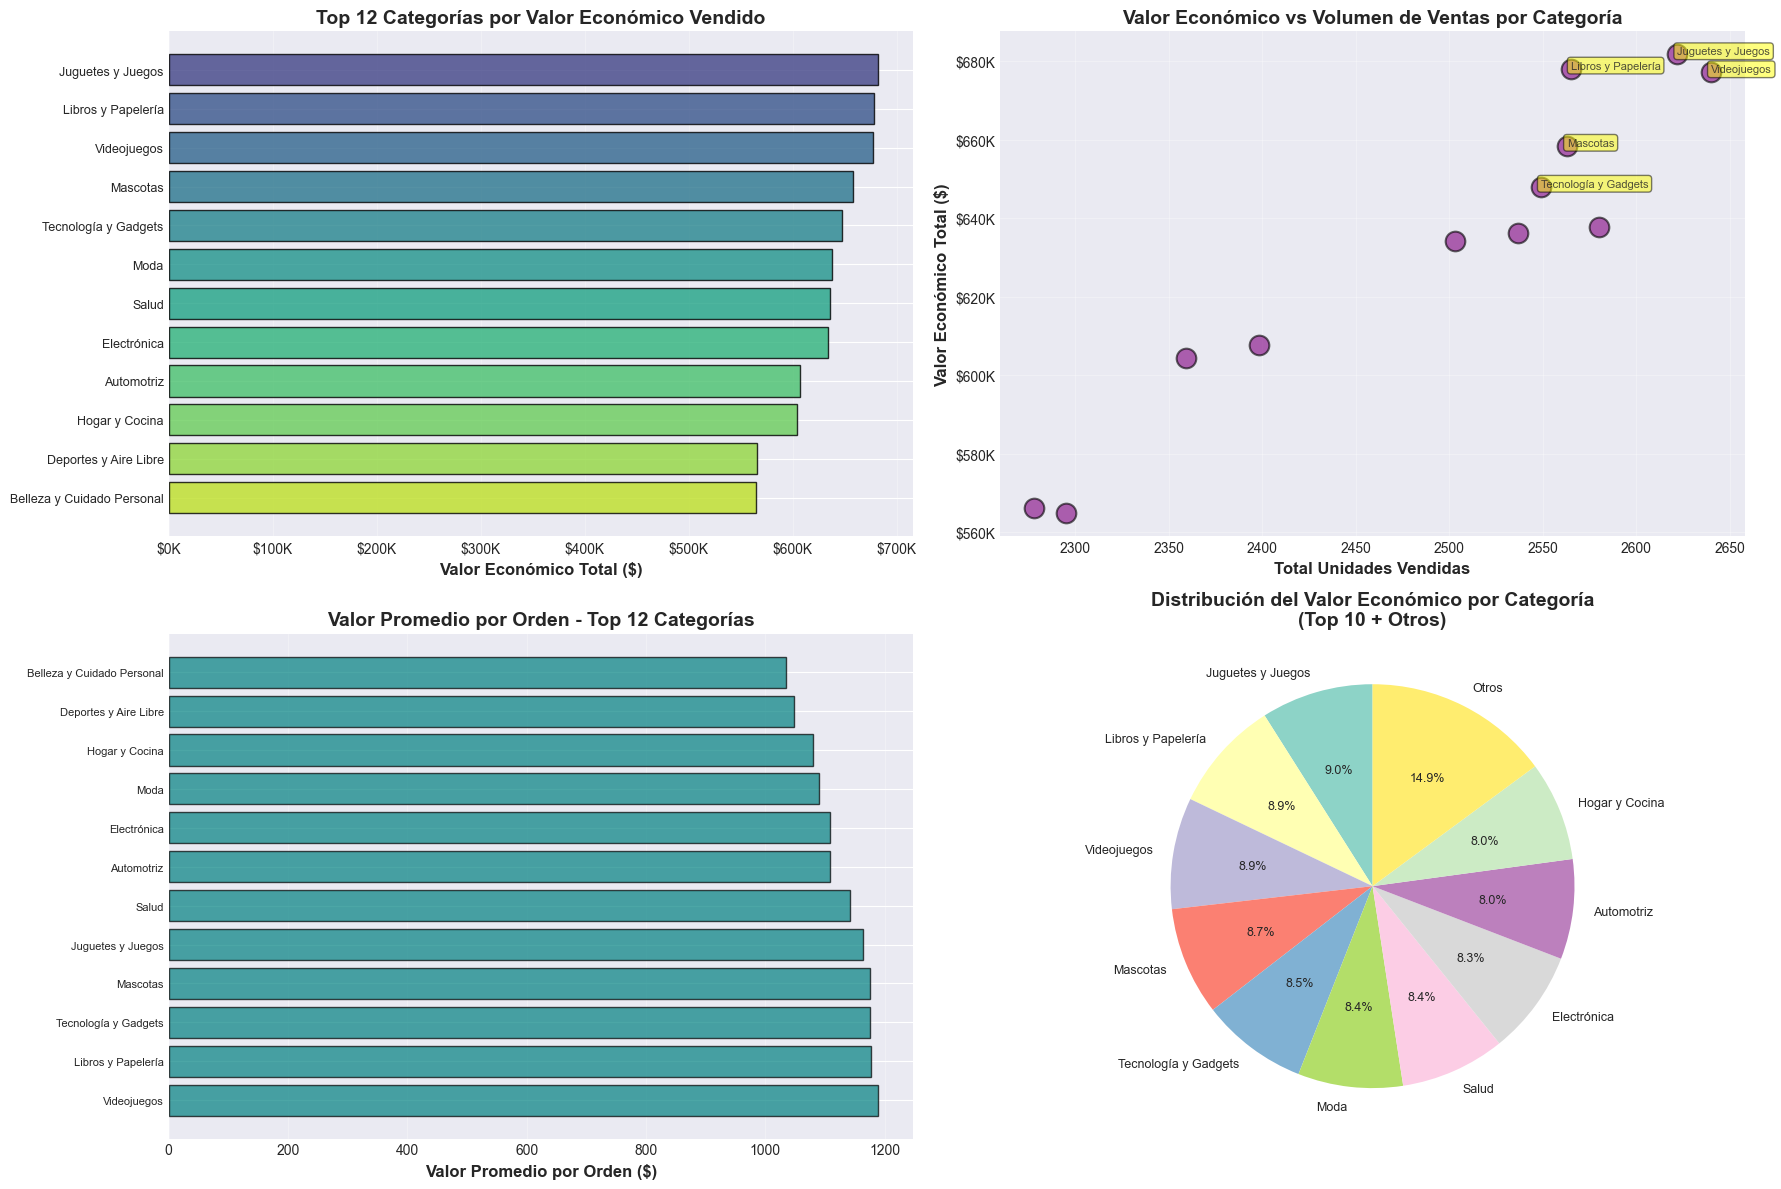


📊 Resumen:
   • Total de categorías analizadas: 12
   • Categoría con mayor valor económico: Juguetes y Juegos
   • Valor económico total de la categoría top: $681,765.17
   • Unidades vendidas de la categoría top: 2,622
   • Valor promedio por orden (categoría top): $1,163.42
   • Valor económico total (todas las categorías): $7,594,525.94
   • Porcentaje del valor total que representa la categoría top: 8.98%


In [17]:
# Consulta SQL para identificar categorías con mayor valor económico vendido
query_categoria_valor_economico = """
SELECT 
    c.categoria_id,
    c.nombre AS categoria_nombre,
    c.descripcion AS categoria_descripcion,
    COUNT(DISTINCT p.producto_id) AS total_productos,
    COUNT(DISTINCT detalle.orden_id) AS total_ordenes,
    SUM(detalle.cantidad) AS total_unidades_vendidas,
    SUM(detalle.cantidad * detalle.precio_unitario) AS valor_economico_total,
    ROUND(AVG(detalle.precio_unitario)::numeric, 2) AS precio_promedio,
    ROUND((SUM(detalle.cantidad * detalle.precio_unitario) / NULLIF(SUM(detalle.cantidad), 0))::numeric, 2) AS ticket_promedio_producto,
    ROUND(SUM(detalle.cantidad * detalle.precio_unitario)::numeric / NULLIF(COUNT(DISTINCT detalle.orden_id), 0), 2) AS valor_promedio_por_orden
FROM categorias c
INNER JOIN productos p ON c.categoria_id = p.categoria_id
INNER JOIN detalle_ordenes detalle ON p.producto_id = detalle.producto_id
GROUP BY c.categoria_id, c.nombre, c.descripcion
ORDER BY valor_economico_total DESC;
"""

df_categoria_valor = pd.read_sql(query_categoria_valor_economico, engine)

print("=" * 100)
print("CATEGORÍAS POR VALOR ECONÓMICO VENDIDO")
print("=" * 100)
print(df_categoria_valor.to_string(index=False))

# Visualización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Top 12 categorías por valor económico
top_15_categorias = df_categoria_valor.head(15)
colors_cat = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_15_categorias)))
ax1.barh(range(len(top_15_categorias)), top_15_categorias['valor_economico_total'], 
        color=colors_cat, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_yticks(range(len(top_15_categorias)))
ax1.set_yticklabels([f"{row['categoria_nombre'][:45]}" 
                     for _, row in top_15_categorias.iterrows()], fontsize=9)
ax1.set_xlabel('Valor Económico Total ($)', fontsize=12, fontweight='bold')
ax1.set_title('Top 12 Categorías por Valor Económico Vendido', 
             fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Formatear el eje x para mostrar valores en miles/millones
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K' if x < 1000000 else f'${x/1000000:.1f}M'))

# Gráfico 2: Comparación Valor Económico vs Volumen
ax2.scatter(df_categoria_valor['total_unidades_vendidas'], 
           df_categoria_valor['valor_economico_total'],
           s=200, alpha=0.6, c='purple', edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Total Unidades Vendidas', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valor Económico Total ($)', fontsize=12, fontweight='bold')
ax2.set_title('Valor Económico vs Volumen de Ventas por Categoría', 
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K' if x < 1000000 else f'${x/1000000:.1f}M'))

# Agregar etiquetas para las top 5 categorías
for idx, row in df_categoria_valor.head(5).iterrows():
    ax2.annotate(row['categoria_nombre'][:25], 
                (row['total_unidades_vendidas'], row['valor_economico_total']),
                fontsize=8, alpha=0.8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# Gráfico 3: Valor promedio por orden por categoría
top_12_categorias_sorted = top_15_categorias.sort_values('valor_promedio_por_orden', ascending=True)
ax3.barh(range(len(top_12_categorias_sorted)), top_12_categorias_sorted['valor_promedio_por_orden'], 
        color='teal', alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(top_12_categorias_sorted)))
ax3.set_yticklabels([f"{row['categoria_nombre'][:40]}" 
                     for _, row in top_12_categorias_sorted.iterrows()], fontsize=8)
ax3.set_xlabel('Valor Promedio por Orden ($)', fontsize=12, fontweight='bold')
ax3.set_title('Valor Promedio por Orden - Top 12 Categorías', 
             fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# Gráfico 4: Distribución de valor económico (pie chart)
top_10_cat = df_categoria_valor.head(10)
otros_valor = df_categoria_valor.iloc[10:]['valor_economico_total'].sum() if len(df_categoria_valor) > 10 else 0

labels_pie = list(top_10_cat['categoria_nombre']) + (['Otros'] if otros_valor > 0 else [])
sizes_pie = list(top_10_cat['valor_economico_total']) + ([otros_valor] if otros_valor > 0 else [])
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(labels_pie)))

ax4.pie(sizes_pie, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 9})
ax4.set_title('Distribución del Valor Económico por Categoría\n(Top 10 + Otros)', 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Total de categorías analizadas: {len(df_categoria_valor)}")
if len(df_categoria_valor) > 0:
    print(f"   • Categoría con mayor valor económico: {df_categoria_valor.iloc[0]['categoria_nombre']}")
    print(f"   • Valor económico total de la categoría top: ${df_categoria_valor.iloc[0]['valor_economico_total']:,.2f}")
    print(f"   • Unidades vendidas de la categoría top: {df_categoria_valor.iloc[0]['total_unidades_vendidas']:,.0f}")
    print(f"   • Valor promedio por orden (categoría top): ${df_categoria_valor.iloc[0]['valor_promedio_por_orden']:,.2f}")
    print(f"   • Valor económico total (todas las categorías): ${df_categoria_valor['valor_economico_total'].sum():,.2f}")
    print(f"   • Porcentaje del valor total que representa la categoría top: {(df_categoria_valor.iloc[0]['valor_economico_total'] / df_categoria_valor['valor_economico_total'].sum() * 100):.2f}%")
